Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


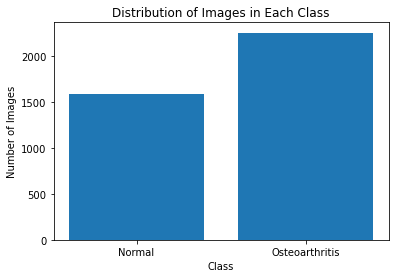

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-24 11:08:17.379770: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 11:08:17.379977: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:08:17.382600: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:08:17.403353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 11:08:17.846984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


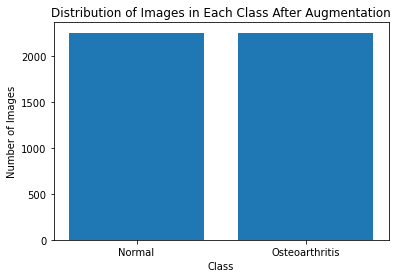

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 1500)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 1500)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 1500 + [1] * 1500  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 1680
X_test size: 900
X_validation size: 420


In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef

# ResNet

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)



# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 43s 796ms/step - loss: 0.5049 - accuracy: 0.7780 - val_loss: 0.4010 - val_accuracy: 0.8262
Epoch 2/50
53/53 [==============================] - 42s 800ms/step - loss: 0.3538 - accuracy: 0.8310 - val_loss: 0.3655 - val_accuracy: 0.8619
Epoch 3/50
53/53 [==============================] - 43s 824ms/step - loss: 0.2993 - accuracy: 0.8768 - val_loss: 0.3555 - val_accuracy: 0.8524
Epoch 4/50
53/53 [==============================] - 43s 820ms/step - loss: 0.2886 - accuracy: 0.8774 - val_loss: 0.3191 - val_accuracy: 0.8571
Epoch 5/50
53/53 [==============================] - 43s 819ms/step - loss: 0.2294 - accuracy: 0.9048 - val_loss: 0.3064 - val_accuracy: 0.8857
Epoch 6/50
53/53 [==============================] - 43s 819ms/step - loss: 0.2655 - accuracy: 0.8821 - val_loss: 0.3557 - val_accuracy: 0.8548
Epoch 7/50
53/53 [==============================] - 43s 820ms/step - loss: 0.1969 - accuracy: 0.9173 - val_loss: 0.2967 - val_accuracy: 0.8857

29/29 [==============================] - 19s 639ms/step
Inference Time: 19.186994791030884 seconds
14/14 [==============================] - 9s 615ms/step - loss: 0.2912 - accuracy: 0.8786
Validation Loss: 0.2912474274635315
Validation Accuracy: 0.8785714507102966
29/29 [==============================] - 19s 638ms/step - loss: 0.2979 - accuracy: 0.8700
Test Loss: 0.2978934943675995
Test Accuracy: 0.8700000047683716
ROC AUC Score: 0.9483197367315779
Confusion Matrix:
[[401  60]
 [ 57 382]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       461
           1       0.86      0.87      0.87       439

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



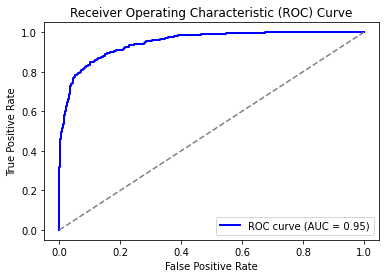

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 44s 825ms/step - loss: 0.2131 - accuracy: 0.9018 - val_loss: 0.3455 - val_accuracy: 0.8643
Epoch 2/100
53/53 [==============================] - 43s 820ms/step - loss: 0.1905 - accuracy: 0.9196 - val_loss: 0.3903 - val_accuracy: 0.8476
Epoch 3/100
53/53 [==============================] - 43s 821ms/step - loss: 0.1715 - accuracy: 0.9298 - val_loss: 0.4460 - val_accuracy: 0.8214
Epoch 4/100
53/53 [==============================] - 43s 821ms/step - loss: 0.1487 - accuracy: 0.9393 - val_loss: 0.2881 - val_accuracy: 0.8881
Epoch 5/100
53/53 [==============================] - 43s 820ms/step - loss: 0.1312 - accuracy: 0.9524 - val_loss: 0.3333 - val_accuracy: 0.8833
Epoch 6/100
53/53 [==============================] - 43s 821ms/step - loss: 0.1031 - accuracy: 0.9637 - val_loss: 0.3801 - val_accuracy: 0.8714
Epoch 7/100
53/53 [==============================] - 43s 819ms/step - loss: 0.0946 - accuracy: 0.9673 - val_loss: 0.4234 - val_accuracy:

29/29 [==============================] - 19s 639ms/step
Inference Time: 18.857945919036865 seconds
14/14 [==============================] - 9s 613ms/step - loss: 0.2881 - accuracy: 0.8881
Validation Loss: 0.28813233971595764
Validation Accuracy: 0.8880952596664429
29/29 [==============================] - 19s 639ms/step - loss: 0.2928 - accuracy: 0.8789
Test Loss: 0.2927617132663727
Test Accuracy: 0.8788889050483704
ROC AUC Score: 0.9528409568186422
Confusion Matrix:
[[425  36]
 [ 73 366]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       461
           1       0.91      0.83      0.87       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



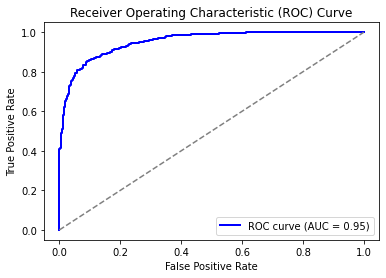

Metrics saved successfully


In [13]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 43s 823ms/step - loss: 0.1302 - accuracy: 0.9476 - val_loss: 0.3177 - val_accuracy: 0.8833
Epoch 2/150
53/53 [==============================] - 43s 820ms/step - loss: 0.1255 - accuracy: 0.9518 - val_loss: 0.4542 - val_accuracy: 0.8500
Epoch 3/150
53/53 [==============================] - 43s 820ms/step - loss: 0.1203 - accuracy: 0.9488 - val_loss: 0.3470 - val_accuracy: 0.8810
Epoch 4/150
53/53 [==============================] - 43s 820ms/step - loss: 0.1059 - accuracy: 0.9619 - val_loss: 0.2968 - val_accuracy: 0.8905
Epoch 5/150
53/53 [==============================] - 43s 819ms/step - loss: 0.0948 - accuracy: 0.9625 - val_loss: 0.4159 - val_accuracy: 0.8667
Epoch 6/150
53/53 [==============================] - 43s 821ms/step - loss: 0.0812 - accuracy: 0.9738 - val_loss: 0.4287 - val_accuracy: 0.8595
Epoch 7/150
53/53 [==============================] - 43s 821ms/step - loss: 0.0666 - accuracy: 0.9774 - val_loss: 0.3460 - val_accuracy:

29/29 [==============================] - 19s 637ms/step
Inference Time: 18.78963875770569 seconds
14/14 [==============================] - 9s 615ms/step - loss: 0.2968 - accuracy: 0.8905
Validation Loss: 0.2968296408653259
Validation Accuracy: 0.8904761672019958
29/29 [==============================] - 19s 639ms/step - loss: 0.2837 - accuracy: 0.8778
Test Loss: 0.2837005853652954
Test Accuracy: 0.8777777552604675
ROC AUC Score: 0.9575548846471225
Confusion Matrix:
[[405  56]
 [ 54 385]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       461
           1       0.87      0.88      0.88       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



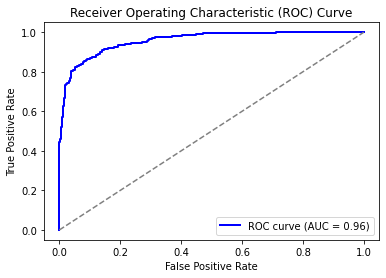

Metrics saved successfully


In [15]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [16]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 43s 822ms/step - loss: 0.0729 - accuracy: 0.9714 - val_loss: 0.3112 - val_accuracy: 0.8857
Epoch 2/200
53/53 [==============================] - 43s 820ms/step - loss: 0.0587 - accuracy: 0.9827 - val_loss: 0.3276 - val_accuracy: 0.8976
Epoch 3/200
53/53 [==============================] - 43s 819ms/step - loss: 0.0623 - accuracy: 0.9804 - val_loss: 0.4331 - val_accuracy: 0.8690
Epoch 4/200
53/53 [==============================] - 43s 821ms/step - loss: 0.1144 - accuracy: 0.9518 - val_loss: 0.3519 - val_accuracy: 0.8976
Epoch 5/200
53/53 [==============================] - 43s 819ms/step - loss: 0.0515 - accuracy: 0.9869 - val_loss: 0.3780 - val_accuracy: 0.8857
Epoch 6/200
53/53 [==============================] - 43s 821ms/step - loss: 0.0825 - accuracy: 0.9685 - val_loss: 0.3585 - val_accuracy: 0.8786
Training Time: 260.37228417396545 seconds


29/29 [==============================] - 19s 638ms/step
Inference Time: 18.80895185470581 seconds
14/14 [==============================] - 9s 615ms/step - loss: 0.3112 - accuracy: 0.8857
Validation Loss: 0.3111844062805176
Validation Accuracy: 0.8857142925262451
29/29 [==============================] - 19s 639ms/step - loss: 0.2973 - accuracy: 0.8767
Test Loss: 0.29733631014823914
Test Accuracy: 0.8766666650772095
ROC AUC Score: 0.9525395421461713
Confusion Matrix:
[[408  53]
 [ 58 381]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       461
           1       0.88      0.87      0.87       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



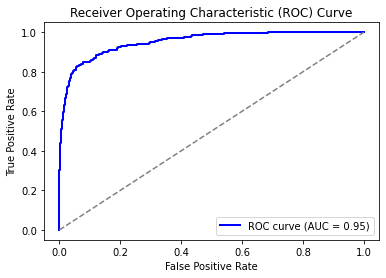

Metrics saved successfully


In [17]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Dense+Dropout

In [5]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(128, activation='relu')(x)  # Additional dense layer
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 43s 796ms/step - loss: 0.6499 - accuracy: 0.6595 - val_loss: 0.4445 - val_accuracy: 0.7762
Epoch 2/50
53/53 [==============================] - 43s 806ms/step - loss: 0.4640 - accuracy: 0.7571 - val_loss: 0.3586 - val_accuracy: 0.8690
Epoch 3/50
53/53 [==============================] - 43s 820ms/step - loss: 0.4115 - accuracy: 0.8083 - val_loss: 0.3453 - val_accuracy: 0.8524
Epoch 4/50
53/53 [==============================] - 43s 818ms/step - loss: 0.3724 - accuracy: 0.8256 - val_loss: 0.3892 - val_accuracy: 0.8214
Epoch 5/50
53/53 [==============================] - 43s 818ms/step - loss: 0.3771 - accuracy: 0.8256 - val_loss: 0.3529 - val_accuracy: 0.8595
Epoch 6/50
53/53 [==============================] - 43s 817ms/step - loss: 0.3578 - accuracy: 0.8411 - val_loss: 0.3037 - val_accuracy: 0.8738
Epoch 7/50
53/53 [==============================] - 43s 818ms/step - loss: 0.3512 - accuracy: 0.8417 - val_loss: 0.3167 - val_accuracy: 0.8738

29/29 [==============================] - 17s 601ms/step
Inference Time: 17.721965551376343 seconds
14/14 [==============================] - 9s 606ms/step - loss: 0.2762 - accuracy: 0.8857
Validation Loss: 0.2762127220630646
Validation Accuracy: 0.8857142925262451
29/29 [==============================] - 19s 640ms/step - loss: 0.2988 - accuracy: 0.8633
Test Loss: 0.2987806797027588
Test Accuracy: 0.8633333444595337
ROC AUC Score: 0.9477317310590525
Confusion Matrix:
[[423  38]
 [ 85 354]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       461
           1       0.90      0.81      0.85       439

    accuracy                           0.86       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.87      0.86      0.86       900



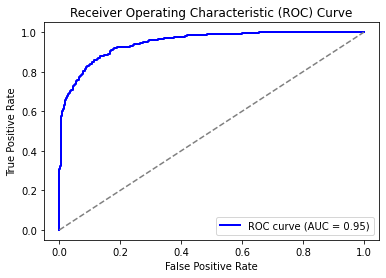

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
import pandas as pd
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 43s 819ms/step - loss: 0.2245 - accuracy: 0.9048 - val_loss: 0.2905 - val_accuracy: 0.8833
Epoch 2/100
53/53 [==============================] - 43s 818ms/step - loss: 0.2304 - accuracy: 0.9000 - val_loss: 0.2905 - val_accuracy: 0.8881
Epoch 3/100
53/53 [==============================] - 43s 817ms/step - loss: 0.2223 - accuracy: 0.8964 - val_loss: 0.3026 - val_accuracy: 0.8786
Epoch 4/100
53/53 [==============================] - 43s 818ms/step - loss: 0.2384 - accuracy: 0.8875 - val_loss: 0.2952 - val_accuracy: 0.8881
Epoch 5/100
53/53 [==============================] - 43s 817ms/step - loss: 0.2459 - accuracy: 0.9000 - val_loss: 0.2877 - val_accuracy: 0.8929
Epoch 6/100
53/53 [==============================] - 43s 817ms/step - loss: 0.2270 - accuracy: 0.9036 - val_loss: 0.2829 - val_accuracy: 0.8881
Epoch 7/100
53/53 [==============================] - 43s 817ms/step - loss: 0.2468 - accuracy: 0.9012 - val_loss: 0.3252 - val_accuracy:

29/29 [==============================] - 19s 636ms/step
Inference Time: 18.757272720336914 seconds
14/14 [==============================] - 9s 613ms/step - loss: 0.2829 - accuracy: 0.8881
Validation Loss: 0.28289225697517395
Validation Accuracy: 0.8880952596664429
29/29 [==============================] - 19s 637ms/step - loss: 0.2971 - accuracy: 0.8722
Test Loss: 0.2971445620059967
Test Accuracy: 0.8722222447395325
ROC AUC Score: 0.9472969033348322
Confusion Matrix:
[[405  56]
 [ 59 380]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       461
           1       0.87      0.87      0.87       439

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



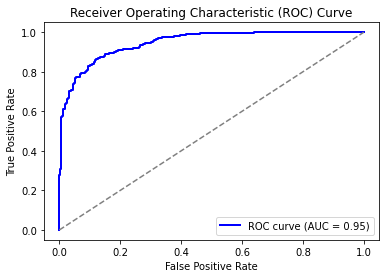

Metrics saved successfully


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 43s 823ms/step - loss: 0.2147 - accuracy: 0.9036 - val_loss: 0.3095 - val_accuracy: 0.8810
Epoch 2/150
53/53 [==============================] - 43s 818ms/step - loss: 0.2146 - accuracy: 0.9012 - val_loss: 0.2990 - val_accuracy: 0.8881
Epoch 3/150
53/53 [==============================] - 43s 817ms/step - loss: 0.2018 - accuracy: 0.9167 - val_loss: 0.3536 - val_accuracy: 0.8619
Epoch 4/150
53/53 [==============================] - 43s 817ms/step - loss: 0.2216 - accuracy: 0.8929 - val_loss: 0.2975 - val_accuracy: 0.8857
Epoch 5/150
53/53 [==============================] - 43s 817ms/step - loss: 0.2094 - accuracy: 0.9089 - val_loss: 0.3143 - val_accuracy: 0.8762
Epoch 6/150
53/53 [==============================] - 43s 818ms/step - loss: 0.2121 - accuracy: 0.9024 - val_loss: 0.2844 - val_accuracy: 0.8810
Epoch 7/150
53/53 [==============================] - 43s 817ms/step - loss: 0.1860 - accuracy: 0.9208 - val_loss: 0.3054 - val_accuracy:

In [12]:
import pandas as pd

29/29 [==============================] - 18s 635ms/step
Inference Time: 18.72293972969055 seconds
14/14 [==============================] - 9s 610ms/step - loss: 0.2844 - accuracy: 0.8810
Validation Loss: 0.28441688418388367
Validation Accuracy: 0.8809523582458496
29/29 [==============================] - 18s 635ms/step - loss: 0.2899 - accuracy: 0.8744
Test Loss: 0.28987276554107666
Test Accuracy: 0.8744444251060486
ROC AUC Score: 0.9519960074908959
Confusion Matrix:
[[417  44]
 [ 69 370]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       461
           1       0.89      0.84      0.87       439

    accuracy                           0.87       900
   macro avg       0.88      0.87      0.87       900
weighted avg       0.88      0.87      0.87       900



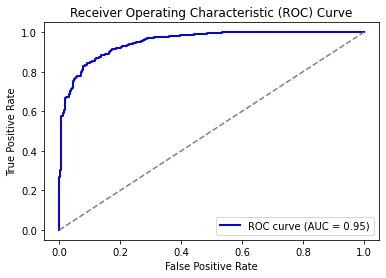

Metrics saved successfully


In [13]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 43s 819ms/step - loss: 0.2021 - accuracy: 0.9077 - val_loss: 0.3213 - val_accuracy: 0.8833
Epoch 2/200
53/53 [==============================] - 43s 817ms/step - loss: 0.2000 - accuracy: 0.9149 - val_loss: 0.2989 - val_accuracy: 0.8857
Epoch 3/200
53/53 [==============================] - 43s 816ms/step - loss: 0.2469 - accuracy: 0.8982 - val_loss: 0.3106 - val_accuracy: 0.8714
Epoch 4/200
53/53 [==============================] - 43s 817ms/step - loss: 0.2268 - accuracy: 0.9006 - val_loss: 0.3315 - val_accuracy: 0.8833
Epoch 5/200
53/53 [==============================] - 43s 817ms/step - loss: 0.1959 - accuracy: 0.9167 - val_loss: 0.3138 - val_accuracy: 0.8952
Epoch 6/200
53/53 [==============================] - 43s 819ms/step - loss: 0.1842 - accuracy: 0.9185 - val_loss: 0.3494 - val_accuracy: 0.8857
Epoch 7/200
53/53 [==============================] - 43s 817ms/step - loss: 0.1968 - accuracy: 0.9095 - val_loss: 0.3557 - val_accuracy:

29/29 [==============================] - 18s 635ms/step
Inference Time: 18.735907554626465 seconds
14/14 [==============================] - 9s 613ms/step - loss: 0.2989 - accuracy: 0.8857
Validation Loss: 0.2988899350166321
Validation Accuracy: 0.8857142925262451
29/29 [==============================] - 18s 635ms/step - loss: 0.3017 - accuracy: 0.8633
Test Loss: 0.3016952574253082
Test Accuracy: 0.8633333444595337
ROC AUC Score: 0.9466644266450571
Confusion Matrix:
[[418  43]
 [ 80 359]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       461
           1       0.89      0.82      0.85       439

    accuracy                           0.86       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.87      0.86      0.86       900



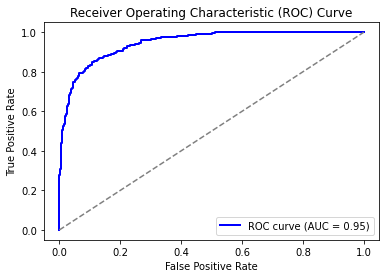

Metrics saved successfully


In [15]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [17]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 45s 835ms/step - loss: 0.7643 - accuracy: 0.6286 - val_loss: 0.4837 - val_accuracy: 0.7429
Epoch 2/50
53/53 [==============================] - 44s 828ms/step - loss: 0.4838 - accuracy: 0.7452 - val_loss: 0.4055 - val_accuracy: 0.8143
Epoch 3/50
53/53 [==============================] - 44s 826ms/step - loss: 0.4266 - accuracy: 0.7964 - val_loss: 0.3386 - val_accuracy: 0.8571
Epoch 4/50
53/53 [==============================] - 44s 825ms/step - loss: 0.4093 - accuracy: 0.8030 - val_loss: 0.3318 - val_accuracy: 0.8571
Epoch 5/50
53/53 [==============================] - 44s 825ms/step - loss: 0.3985 - accuracy: 0.8060 - val_loss: 0.3782 - val_accuracy: 0.8738
Epoch 6/50
53/53 [==============================] - 44s 824ms/step - loss: 0.3815 - accuracy: 0.8107 - val_loss: 0.3090 - val_accuracy: 0.8571
Epoch 7/50
53/53 [==============================] - 44s 826ms/step - loss: 0.3828 - accuracy: 0.8042 - val_loss: 0.3078 - val_accuracy: 0.8619

29/29 [==============================] - 19s 641ms/step
Inference Time: 19.183064937591553 seconds
14/14 [==============================] - 9s 617ms/step - loss: 0.2561 - accuracy: 0.8762
Validation Loss: 0.25611233711242676
Validation Accuracy: 0.8761904835700989
29/29 [==============================] - 19s 636ms/step - loss: 0.2937 - accuracy: 0.8756
Test Loss: 0.29365840554237366
Test Accuracy: 0.8755555748939514
ROC AUC Score: 0.9474649049555536
Confusion Matrix:
[[409  52]
 [ 60 379]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       461
           1       0.88      0.86      0.87       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



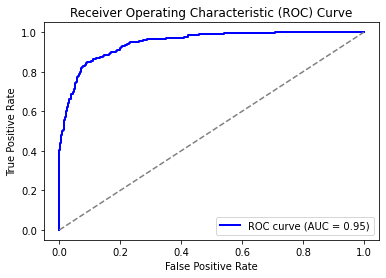

Metrics saved successfully


In [18]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [19]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 44s 827ms/step - loss: 0.2622 - accuracy: 0.8810 - val_loss: 0.2708 - val_accuracy: 0.8857
Epoch 2/100
53/53 [==============================] - 43s 824ms/step - loss: 0.2389 - accuracy: 0.9006 - val_loss: 0.2642 - val_accuracy: 0.8905
Epoch 3/100
53/53 [==============================] - 44s 831ms/step - loss: 0.2223 - accuracy: 0.9137 - val_loss: 0.2623 - val_accuracy: 0.8810
Epoch 4/100
53/53 [==============================] - 44s 825ms/step - loss: 0.2038 - accuracy: 0.9137 - val_loss: 0.2505 - val_accuracy: 0.8929
Epoch 5/100
53/53 [==============================] - 44s 828ms/step - loss: 0.2052 - accuracy: 0.9179 - val_loss: 0.2887 - val_accuracy: 0.8833
Epoch 6/100
53/53 [==============================] - 45s 846ms/step - loss: 0.1950 - accuracy: 0.9173 - val_loss: 0.3156 - val_accuracy: 0.8667
Epoch 7/100
53/53 [==============================] - 44s 825ms/step - loss: 0.2499 - accuracy: 0.8815 - val_loss: 0.2953 - val_accuracy:

29/29 [==============================] - 20s 672ms/step
Inference Time: 19.77824592590332 seconds
14/14 [==============================] - 9s 642ms/step - loss: 0.2505 - accuracy: 0.8929
Validation Loss: 0.2504970133304596
Validation Accuracy: 0.8928571343421936
29/29 [==============================] - 19s 657ms/step - loss: 0.2848 - accuracy: 0.8789
Test Loss: 0.28479593992233276
Test Accuracy: 0.8788889050483704
ROC AUC Score: 0.9544765020086077
Confusion Matrix:
[[420  41]
 [ 68 371]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       461
           1       0.90      0.85      0.87       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



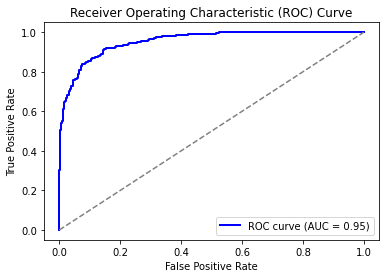

Metrics saved successfully


In [20]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [21]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 44s 841ms/step - loss: 0.2087 - accuracy: 0.9060 - val_loss: 0.3702 - val_accuracy: 0.8619
Epoch 2/150
53/53 [==============================] - 43s 823ms/step - loss: 0.2175 - accuracy: 0.9089 - val_loss: 0.2714 - val_accuracy: 0.8762
Epoch 3/150
53/53 [==============================] - 44s 826ms/step - loss: 0.1693 - accuracy: 0.9339 - val_loss: 0.2706 - val_accuracy: 0.8929
Epoch 4/150
53/53 [==============================] - 44s 827ms/step - loss: 0.1772 - accuracy: 0.9274 - val_loss: 0.2680 - val_accuracy: 0.8952
Epoch 5/150
53/53 [==============================] - 43s 823ms/step - loss: 0.1618 - accuracy: 0.9399 - val_loss: 0.2583 - val_accuracy: 0.8952
Epoch 6/150
53/53 [==============================] - 44s 829ms/step - loss: 0.1367 - accuracy: 0.9500 - val_loss: 0.2876 - val_accuracy: 0.8738
Epoch 7/150
53/53 [==============================] - 44s 826ms/step - loss: 0.1271 - accuracy: 0.9536 - val_loss: 0.2863 - val_accuracy:

29/29 [==============================] - 18s 636ms/step
Inference Time: 18.796600580215454 seconds
14/14 [==============================] - 9s 612ms/step - loss: 0.2583 - accuracy: 0.8952
Validation Loss: 0.25828495621681213
Validation Accuracy: 0.8952381014823914
29/29 [==============================] - 18s 635ms/step - loss: 0.2799 - accuracy: 0.8867
Test Loss: 0.27987611293792725
Test Accuracy: 0.8866666555404663
ROC AUC Score: 0.9563887557503497
Confusion Matrix:
[[422  39]
 [ 63 376]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       461
           1       0.91      0.86      0.88       439

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



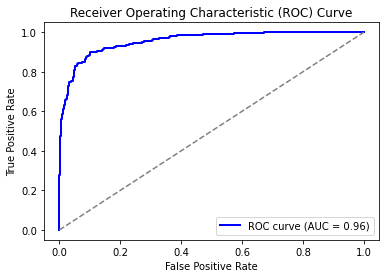

Metrics saved successfully


In [22]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 44s 806ms/step - loss: 0.8480 - accuracy: 0.5988 - val_loss: 0.4472 - val_accuracy: 0.8333
Epoch 2/200
53/53 [==============================] - 43s 815ms/step - loss: 0.5115 - accuracy: 0.7125 - val_loss: 0.3516 - val_accuracy: 0.8500
Epoch 3/200
53/53 [==============================] - 44s 829ms/step - loss: 0.4634 - accuracy: 0.7506 - val_loss: 0.3631 - val_accuracy: 0.8714
Epoch 4/200
53/53 [==============================] - 44s 829ms/step - loss: 0.4313 - accuracy: 0.7786 - val_loss: 0.3276 - val_accuracy: 0.8667
Epoch 5/200
53/53 [==============================] - 44s 826ms/step - loss: 0.3993 - accuracy: 0.7976 - val_loss: 0.3454 - val_accuracy: 0.8786
Epoch 6/200
53/53 [==============================] - 44s 826ms/step - loss: 0.3764 - accuracy: 0.8155 - val_loss: 0.3449 - val_accuracy: 0.8714
Epoch 7/200
53/53 [==============================] - 44s 827ms/step - loss: 0.3627 - accuracy: 0.8232 - val_loss: 0.2973 - val_accuracy:

29/29 [==============================] - 18s 625ms/step
Inference Time: 18.406590461730957 seconds
14/14 [==============================] - 9s 616ms/step - loss: 0.2453 - accuracy: 0.8762
Validation Loss: 0.24531789124011993
Validation Accuracy: 0.8761904835700989
29/29 [==============================] - 18s 632ms/step - loss: 0.2916 - accuracy: 0.8778
Test Loss: 0.2916460931301117
Test Accuracy: 0.8777777552604675
ROC AUC Score: 0.9504494043354301
Confusion Matrix:
[[428  33]
 [ 77 362]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       461
           1       0.92      0.82      0.87       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



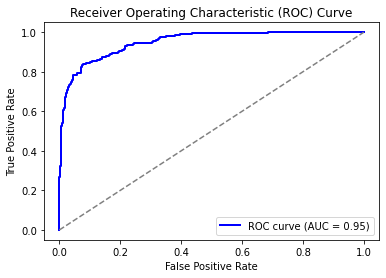

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score,balanced_accuracy_score,matthews_corrcoef
import pandas as pd
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+LSTM+Dense

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for LSTM
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# LSTM layer
lstm_output = LSTM(128)(reshaped_output)

# Dense layer for classification
dense_output = Dense(64, activation='relu')(lstm_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 60s 1s/step - loss: 0.5994 - accuracy: 0.6744 - val_loss: 0.5533 - val_accuracy: 0.7286
Epoch 2/50
53/53 [==============================] - 58s 1s/step - loss: 0.5238 - accuracy: 0.7440 - val_loss: 0.5069 - val_accuracy: 0.7881
Epoch 3/50
53/53 [==============================] - 57s 1s/step - loss: 0.4661 - accuracy: 0.7839 - val_loss: 0.5227 - val_accuracy: 0.7714
Epoch 4/50
53/53 [==============================] - 57s 1s/step - loss: 0.4590 - accuracy: 0.7815 - val_loss: 0.4268 - val_accuracy: 0.8381
Epoch 5/50
53/53 [==============================] - 57s 1s/step - loss: 0.4309 - accuracy: 0.8107 - val_loss: 0.3834 - val_accuracy: 0.8429
Epoch 6/50
53/53 [==============================] - 57s 1s/step - loss: 0.4655 - accuracy: 0.7726 - val_loss: 0.4458 - val_accuracy: 0.8095
Epoch 7/50
53/53 [==============================] - 57s 1s/step - loss: 0.4559 - accuracy: 0.7696 - val_loss: 0.4715 - val_accuracy: 0.7881
Epoch 8/50
53/53 [==

29/29 [==============================] - 19s 647ms/step
Inference Time: 19.53335928916931 seconds
14/14 [==============================] - 9s 624ms/step - loss: 0.3834 - accuracy: 0.8429
Validation Loss: 0.3834018409252167
Validation Accuracy: 0.8428571224212646
29/29 [==============================] - 19s 647ms/step - loss: 0.4443 - accuracy: 0.7911
Test Loss: 0.4443264305591583
Test Accuracy: 0.7911111116409302
ROC AUC Score: 0.8794390722357557
Confusion Matrix:
[[392  69]
 [119 320]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       461
           1       0.82      0.73      0.77       439

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.79      0.79      0.79       900



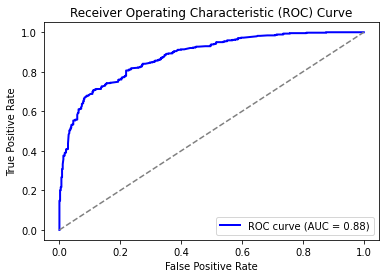

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [13]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 58s 1s/step - loss: 0.4033 - accuracy: 0.8226 - val_loss: 0.4425 - val_accuracy: 0.7905
Epoch 2/100
53/53 [==============================] - 57s 1s/step - loss: 0.4163 - accuracy: 0.8185 - val_loss: 0.4308 - val_accuracy: 0.7929
Epoch 3/100
53/53 [==============================] - 57s 1s/step - loss: 0.4267 - accuracy: 0.7899 - val_loss: 0.4401 - val_accuracy: 0.7667
Epoch 4/100
53/53 [==============================] - 57s 1s/step - loss: 0.4367 - accuracy: 0.7929 - val_loss: 0.4735 - val_accuracy: 0.7381
Epoch 5/100
53/53 [==============================] - 57s 1s/step - loss: 0.4021 - accuracy: 0.8232 - val_loss: 0.5029 - val_accuracy: 0.7714
Epoch 6/100
53/53 [==============================] - 57s 1s/step - loss: 0.4301 - accuracy: 0.7815 - val_loss: 0.4801 - val_accuracy: 0.7714
Epoch 7/100
53/53 [==============================] - 57s 1s/step - loss: 0.4054 - accuracy: 0.8173 - val_loss: 0.4053 - val_accuracy: 0.8238
Epoch 8/100
5

29/29 [==============================] - 19s 648ms/step
Inference Time: 19.10409665107727 seconds
14/14 [==============================] - 9s 622ms/step - loss: 0.4053 - accuracy: 0.8238
Validation Loss: 0.4052705764770508
Validation Accuracy: 0.8238095045089722
29/29 [==============================] - 19s 647ms/step - loss: 0.4361 - accuracy: 0.7778
Test Loss: 0.4361114799976349
Test Accuracy: 0.7777777910232544
ROC AUC Score: 0.8921157827640219
Confusion Matrix:
[[310 151]
 [ 49 390]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76       461
           1       0.72      0.89      0.80       439

    accuracy                           0.78       900
   macro avg       0.79      0.78      0.78       900
weighted avg       0.79      0.78      0.78       900



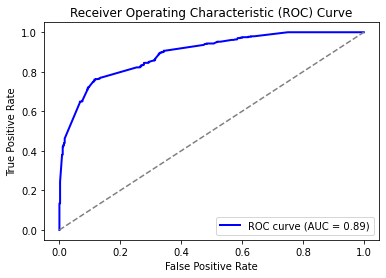

Metrics saved successfully


In [14]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [15]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 [==============================] - 58s 1s/step - loss: 0.3846 - accuracy: 0.8179 - val_loss: 0.4627 - val_accuracy: 0.7571
Epoch 2/150
53/53 [==============================] - 58s 1s/step - loss: 0.3836 - accuracy: 0.8274 - val_loss: 0.4810 - val_accuracy: 0.7857
Epoch 3/150
53/53 [==============================] - 57s 1s/step - loss: 0.3953 - accuracy: 0.8214 - val_loss: 0.4044 - val_accuracy: 0.8333
Epoch 4/150
53/53 [==============================] - 57s 1s/step - loss: 0.3992 - accuracy: 0.8196 - val_loss: 0.3921 - val_accuracy: 0.8310
Epoch 5/150
53/53 [==============================] - 57s 1s/step - loss: 0.3635 - accuracy: 0.8357 - val_loss: 0.4336 - val_accuracy: 0.7881
Epoch 6/150
53/53 [==============================] - 57s 1s/step - loss: 0.4205 - accuracy: 0.8030 - val_loss: 0.4893 - val_accuracy: 0.7524
Epoch 7/150
53/53 [==============================] - 57s 1s/step - loss: 0.3824 - accuracy: 0.8173 - val_loss: 0.3956 - val_accuracy: 0.8405
Epoch 8/150
5

29/29 [==============================] - 19s 649ms/step
Inference Time: 19.117717027664185 seconds
14/14 [==============================] - 9s 624ms/step - loss: 0.3921 - accuracy: 0.8310
Validation Loss: 0.39207181334495544
Validation Accuracy: 0.8309524059295654
29/29 [==============================] - 19s 647ms/step - loss: 0.4052 - accuracy: 0.8100
Test Loss: 0.4052170217037201
Test Accuracy: 0.8100000023841858
ROC AUC Score: 0.8925901402813533
Confusion Matrix:
[[366  95]
 [ 76 363]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       461
           1       0.79      0.83      0.81       439

    accuracy                           0.81       900
   macro avg       0.81      0.81      0.81       900
weighted avg       0.81      0.81      0.81       900



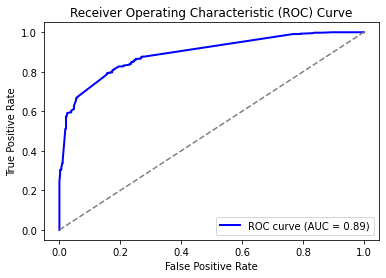

Metrics saved successfully


In [16]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [17]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 [==============================] - 58s 1s/step - loss: 0.3513 - accuracy: 0.8381 - val_loss: 0.4360 - val_accuracy: 0.8024
Epoch 2/200
53/53 [==============================] - 57s 1s/step - loss: 0.3721 - accuracy: 0.8393 - val_loss: 0.4281 - val_accuracy: 0.7738
Epoch 3/200
53/53 [==============================] - 57s 1s/step - loss: 0.3748 - accuracy: 0.8298 - val_loss: 0.4083 - val_accuracy: 0.8429
Epoch 4/200
53/53 [==============================] - 57s 1s/step - loss: 0.3764 - accuracy: 0.8369 - val_loss: 0.4499 - val_accuracy: 0.8048
Epoch 5/200
53/53 [==============================] - 57s 1s/step - loss: 0.3823 - accuracy: 0.8190 - val_loss: 0.4695 - val_accuracy: 0.7357
Epoch 6/200
53/53 [==============================] - 57s 1s/step - loss: 0.3860 - accuracy: 0.8107 - val_loss: 0.5137 - val_accuracy: 0.7167
Epoch 7/200
53/53 [==============================] - 58s 1s/step - loss: 0.3747 - accuracy: 0.8202 - val_loss: 0.3095 - val_accuracy: 0.8548
Epoch 8/200
5

29/29 [==============================] - 19s 648ms/step
Inference Time: 19.076693058013916 seconds
14/14 [==============================] - 9s 623ms/step - loss: 0.3095 - accuracy: 0.8548
Validation Loss: 0.30948570370674133
Validation Accuracy: 0.8547618985176086
29/29 [==============================] - 19s 648ms/step - loss: 0.4247 - accuracy: 0.8200
Test Loss: 0.42471981048583984
Test Accuracy: 0.8199999928474426
ROC AUC Score: 0.8934548545056553
Confusion Matrix:
[[394  67]
 [ 95 344]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       461
           1       0.84      0.78      0.81       439

    accuracy                           0.82       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.82      0.82      0.82       900



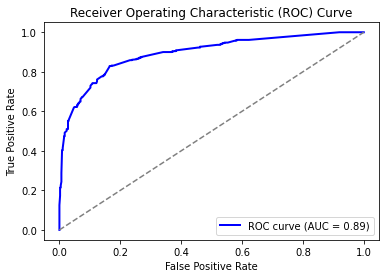

Metrics saved successfully


In [18]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# ResNet+GRU+Dense

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for GRU
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# GRU layer
gru_output = GRU(128)(reshaped_output)

# Dense layers for classification
dense_output = Dense(64, activation='relu')(gru_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 62,181,121 (237.20 MB)

 Trainable params: 38,593,409 (147.22 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 [==============================] - 56s 1s/step - loss: 0.6041 - accuracy: 0.6649 - val_loss: 0.5078 - val_accuracy: 0.7881
Epoch 2/50
53/53 [==============================] - 54s 1s/step - loss: 0.4796 - accuracy: 0.7786 - val_loss: 0.4837 - val_accuracy: 0.7833
Epoch 3/50
53/53 [==============================] - 54s 1s/step - loss: 0.4508 - accuracy: 0.7810 - val_loss: 0.4438 - val_accuracy: 0.7857
Epoch 4/50
53/53 [==============================] - 54s 1s/step - loss: 0.4612 - accuracy: 0.7821 - val_loss: 0.4686 - val_accuracy: 0.7524
Epoch 5/50
53/53 [==============================] - 54s 1s/step - loss: 0.4162 - accuracy: 0.8065 - val_loss: 0.4520 - val_accuracy: 0.7738
Epoch 6/50
53/53 [==============================] - 54s 1s/step - loss: 0.4239 - accuracy: 0.8030 - val_loss: 0.4067 - val_accuracy: 0.8310
Epoch 7/50
53/53 [==============================] - 54s 1s/step - loss: 0.3676 - accuracy: 0.8405 - val_loss: 0.3476 - val_accuracy: 0.8643
Epoch 8/50
53/53 [==

29/29 [==============================] - 19s 644ms/step
Inference Time: 19.387678623199463 seconds
14/14 [==============================] - 9s 623ms/step - loss: 0.3476 - accuracy: 0.8643
Validation Loss: 0.34761136770248413
Validation Accuracy: 0.8642857074737549
29/29 [==============================] - 19s 643ms/step - loss: 0.3916 - accuracy: 0.8278
Test Loss: 0.39158836007118225
Test Accuracy: 0.8277778029441833
ROC AUC Score: 0.9058400328097284
Confusion Matrix:
[[377  84]
 [ 71 368]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       461
           1       0.81      0.84      0.83       439

    accuracy                           0.83       900
   macro avg       0.83      0.83      0.83       900
weighted avg       0.83      0.83      0.83       900



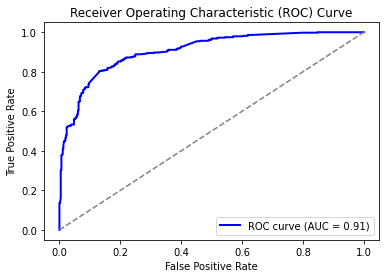

Metrics saved successfully


In [21]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [22]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 [==============================] - 54s 1s/step - loss: 0.3487 - accuracy: 0.8464 - val_loss: 0.3811 - val_accuracy: 0.8310
Epoch 2/100
53/53 [==============================] - 54s 1s/step - loss: 0.3541 - accuracy: 0.8440 - val_loss: 0.3654 - val_accuracy: 0.8452
Epoch 3/100
53/53 [==============================] - 54s 1s/step - loss: 0.3615 - accuracy: 0.8381 - val_loss: 0.4263 - val_accuracy: 0.8238
Epoch 4/100
53/53 [==============================] - 54s 1s/step - loss: 0.3820 - accuracy: 0.8417 - val_loss: 0.3852 - val_accuracy: 0.8190
Epoch 5/100
53/53 [==============================] - 54s 1s/step - loss: 0.4106 - accuracy: 0.8214 - val_loss: 0.3935 - val_accuracy: 0.8310
Epoch 6/100
53/53 [==============================] - 54s 1s/step - loss: 0.5391 - accuracy: 0.7673 - val_loss: 0.4977 - val_accuracy: 0.7643
Epoch 7/100
53/53 [==============================] - 54s 1s/step - loss: 0.3679 - accuracy: 0.8417 - val_loss: 0.4006 - val_accuracy: 0.8214
Training Time

29/29 [==============================] - 19s 652ms/step
Inference Time: 19.530514240264893 seconds
14/14 [==============================] - 9s 623ms/step - loss: 0.3654 - accuracy: 0.8452
Validation Loss: 0.36536097526550293
Validation Accuracy: 0.8452380895614624
29/29 [==============================] - 19s 645ms/step - loss: 0.4125 - accuracy: 0.8089
Test Loss: 0.4125005006790161
Test Accuracy: 0.8088889122009277
ROC AUC Score: 0.8963108820579209
Confusion Matrix:
[[351 110]
 [ 62 377]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       461
           1       0.77      0.86      0.81       439

    accuracy                           0.81       900
   macro avg       0.81      0.81      0.81       900
weighted avg       0.81      0.81      0.81       900



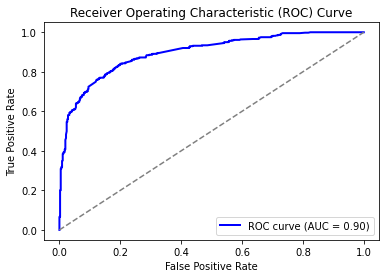

Metrics saved successfully


In [23]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 855ms/step - accuracy: 0.5972 - loss: 0.6970 - val_accuracy: 0.7000 - val_loss: 0.6139
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 884ms/step - accuracy: 0.7164 - loss: 0.5814 - val_accuracy: 0.7214 - val_loss: 0.5273
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 900ms/step - accuracy: 0.7715 - loss: 0.5036 - val_accuracy: 0.7095 - val_loss: 0.5223
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 879ms/step - accuracy: 0.7570 - loss: 0.4928 - val_accuracy: 0.7262 - val_loss: 0.5481
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 879ms/step - accuracy: 0.7877 - loss: 0.4654 - val_accuracy: 0.7762 - val_loss: 0.4538
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 880ms/step - accuracy: 0.8151 - loss: 0.4122 - val_accuracy: 0.7905 - val_loss: 0.4387
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 879ms/step - accuracy: 0.8111 - loss: 0.4033 - val_accuracy: 0.7976 - val_loss: 0.4355
Epoch 8/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 880ms/step - accuracy: 0.8242 - loss: 0.3857 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 559ms/step
Inference Time: 17.032644748687744 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.7595 - loss: 0.4483
Validation Loss: 0.3930799067020416
Validation Accuracy: 0.8023809790611267
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 535ms/step - accuracy: 0.8331 - loss: 0.3573
Test Loss: 0.3754684627056122
Test Accuracy: 0.8222222328186035
ROC AUC Score: 0.9159646010702692
Confusion Matrix:
[[408  53]
 [107 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       461
           1       0.86      0.76      0.81       439

    accuracy                           0.82       900
   macro avg       0.83      0.82      0.82       900
weighted avg       0.83      0.82      0.82       900



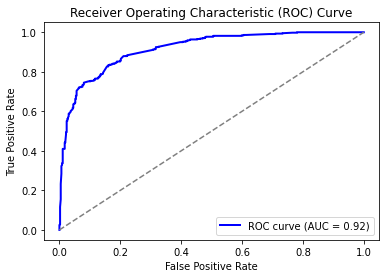

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 883ms/step - accuracy: 0.8324 - loss: 0.3661 - val_accuracy: 0.7714 - val_loss: 0.5077
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 886ms/step - accuracy: 0.8168 - loss: 0.3977 - val_accuracy: 0.7881 - val_loss: 0.4808
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 879ms/step - accuracy: 0.8075 - loss: 0.4049 - val_accuracy: 0.7881 - val_loss: 0.4686
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 879ms/step - accuracy: 0.8392 - loss: 0.3766 - val_accuracy: 0.7381 - val_loss: 0.5448
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 879ms/step - accuracy: 0.7914 - loss: 0.4308 - val_accuracy: 0.7619 - val_loss: 0.4340
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 877ms/step - accuracy: 0.8242 - loss: 0.3994 - val_accuracy: 0.8000 - val_loss: 0.4400
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 878ms/step - accuracy: 0.8215 - loss: 0.3708 - val_accuracy: 0.7381 - val_loss: 0.4615
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 878ms/step - accuracy: 0.7914 - loss: 0.4162 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 534ms/step
Inference Time: 15.773074388504028 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.8070 - loss: 0.4029
Validation Loss: 0.3656452000141144
Validation Accuracy: 0.8214285969734192
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 535ms/step - accuracy: 0.8376 - loss: 0.3826
Test Loss: 0.394844651222229
Test Accuracy: 0.8399999737739563
ROC AUC Score: 0.9040266035507637
Confusion Matrix:
[[390  71]
 [ 73 366]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       461
           1       0.84      0.83      0.84       439

    accuracy                           0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900



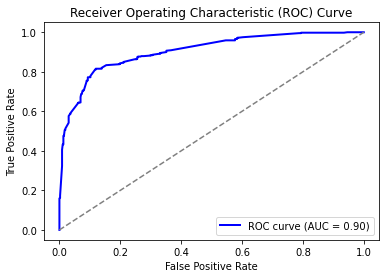

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Attention Mechanism+Dense

In [6]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply, Lambda
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import cv2
import time
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pandas as pd

# Start time
start_time = time.time()

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of ResNet50

# Example: Assuming X_test is another dataset
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
x = GlobalAveragePooling2D()(base_model.output)
x = Reshape((1, -1))(x)  # Reshape to 3D tensor for attention mechanism
attention_probs = Dense(np.prod(x.shape[2:]), activation='softmax', name='attention_probs')(x)
attention_mul = Multiply()([x, attention_probs])
attention_mul = Lambda(lambda x: K.sum(x, axis=1))(attention_mul)  # Sum along the time axis

# Add dense layers for classification
output = Dense(1, activation='sigmoid')(attention_mul)

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 27,786,113 (106.00 MB)

 Trainable params: 4,198,401 (16.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 774ms/step - accuracy: 0.6173 - loss: 0.6704 - val_accuracy: 0.7881 - val_loss: 0.5728
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.8247 - loss: 0.5376 - val_accuracy: 0.8167 - val_loss: 0.4989
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.8499 - loss: 0.4703 - val_accuracy: 0.8119 - val_loss: 0.4575
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - accuracy: 0.8605 - loss: 0.4215 - val_accuracy: 0.8405 - val_loss: 0.4124
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - accuracy: 0.8528 - loss: 0.4078 - val_accuracy: 0.8333 - val_loss: 0.4162
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.8799 - loss: 0.3654 - val_accuracy: 0.8619 - val_loss: 0.3823
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - accuracy: 0.8945 - loss: 0.3321 - val_accuracy: 0.8667 - val_loss: 0.3702
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - accuracy: 0.9009 - loss: 0.3111 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step
Inference Time: 26.363093852996826 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.8673 - loss: 0.3140
Validation Loss: 0.30927321314811707
Validation Accuracy: 0.8785714507102966
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step - accuracy: 0.8743 - loss: 0.2820
Test Loss: 0.3186667263507843
Test Accuracy: 0.8677777647972107
ROC AUC Score: 0.9487397407833816
Confusion Matrix:
[[387  74]
 [ 45 394]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       461
           1       0.84      0.90      0.87       439

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



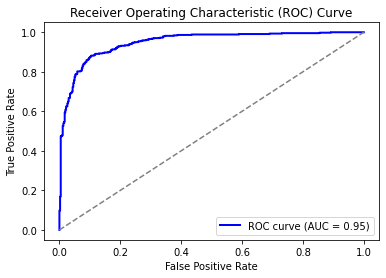

Metrics saved successfully


In [14]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [15]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 761ms/step - accuracy: 0.9435 - loss: 0.1755 - val_accuracy: 0.8810 - val_loss: 0.3115
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.9533 - loss: 0.1708 - val_accuracy: 0.8714 - val_loss: 0.3223
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.9677 - loss: 0.1479 - val_accuracy: 0.8762 - val_loss: 0.3184
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - accuracy: 0.9594 - loss: 0.1497 - val_accuracy: 0.8667 - val_loss: 0.3239
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - accuracy: 0.9584 - loss: 0.1538 - val_accuracy: 0.8762 - val_loss: 0.3741
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.9732 - loss: 0.1235 - val_accuracy: 0.8738 - val_loss: 0.3311
Training Time: 241.74502825737 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step
Inference Time: 15.64354944229126 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.8782 - loss: 0.3128
Validation Loss: 0.31150054931640625
Validation Accuracy: 0.8809523582458496
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step - accuracy: 0.8814 - loss: 0.2821
Test Loss: 0.3145217299461365
Test Accuracy: 0.8788889050483704
ROC AUC Score: 0.9469707825416669
Confusion Matrix:
[[398  63]
 [ 46 393]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       461
           1       0.86      0.90      0.88       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



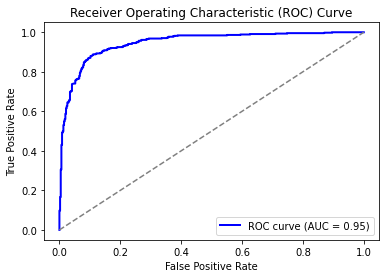

Metrics saved successfully


In [16]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [17]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 763ms/step - accuracy: 0.9643 - loss: 0.1515 - val_accuracy: 0.8381 - val_loss: 0.4716
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 768ms/step - accuracy: 0.9462 - loss: 0.1830 - val_accuracy: 0.8690 - val_loss: 0.3269
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - accuracy: 0.9613 - loss: 0.1586 - val_accuracy: 0.8786 - val_loss: 0.3280
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - accuracy: 0.9694 - loss: 0.1296 - val_accuracy: 0.8619 - val_loss: 0.4299
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - accuracy: 0.9660 - loss: 0.1402 - val_accuracy: 0.8667 - val_loss: 0.3476
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 759ms/step - accuracy: 0.9847 - loss: 0.1014 - val_accuracy: 0.8786 - val_loss: 0.3755
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - accuracy: 0.9793 - loss: 0.1074 - val_accuracy: 0.8619 - val_loss: 0.4884
Training Time: 282.52446484565735 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step
Inference Time: 15.587959051132202 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.8660 - loss: 0.3324
Validation Loss: 0.32685092091560364
Validation Accuracy: 0.8690476417541504
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step - accuracy: 0.8771 - loss: 0.2974
Test Loss: 0.33175861835479736
Test Accuracy: 0.8755555748939514
ROC AUC Score: 0.949322805231768
Confusion Matrix:
[[379  82]
 [ 30 409]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       461
           1       0.83      0.93      0.88       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



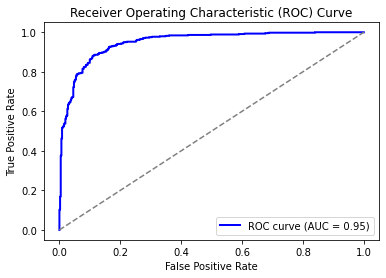

Metrics saved successfully


In [18]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 725ms/step - accuracy: 0.6304 - loss: 0.6730 - val_accuracy: 0.7500 - val_loss: 0.5779
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 733ms/step - accuracy: 0.7955 - loss: 0.5473 - val_accuracy: 0.7976 - val_loss: 0.5203
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 760ms/step - accuracy: 0.8382 - loss: 0.4729 - val_accuracy: 0.8071 - val_loss: 0.4635
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 761ms/step - accuracy: 0.8385 - loss: 0.4284 - val_accuracy: 0.8071 - val_loss: 0.4435
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 761ms/step - accuracy: 0.8695 - loss: 0.3758 - val_accuracy: 0.8167 - val_loss: 0.4232
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 762ms/step - accuracy: 0.8816 - loss: 0.3444 - val_accuracy: 0.8357 - val_loss: 0.4200
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 764ms/step - accuracy: 0.9051 - loss: 0.3085 - val_accuracy: 0.8500 - val_loss: 0.3856
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 763ms/step - accuracy: 0.9046 - loss: 0.2971 - 

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 551ms/step
Inference Time: 16.848958015441895 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - accuracy: 0.8651 - loss: 0.3524
Validation Loss: 0.3212513327598572
Validation Accuracy: 0.8833333253860474
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 536ms/step - accuracy: 0.9016 - loss: 0.2739
Test Loss: 0.28511449694633484
Test Accuracy: 0.8955555558204651
ROC AUC Score: 0.9465260723691687
Confusion Matrix:
[[412  49]
 [ 45 394]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       461
           1       0.89      0.90      0.89       439

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



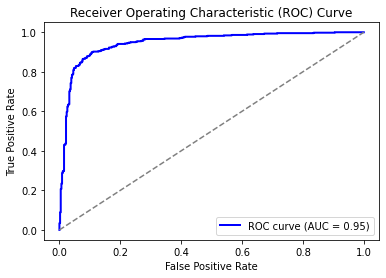

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Capsule Network+Dense

In [10]:
# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j

# Start time
start_time = time.time()

# Assuming X_train and X_test are your training and testing data respectively

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of ResNet50

# Example: Assuming X_test is another dataset
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 2048))(x)  # Reshape to 3D tensor for Capsule Network (2048 is the output dimension of ResNet50)
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,936,129 (91.31 MB)

 Trainable params: 348,417 (1.33 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 638ms/step - accuracy: 0.6538 - loss: 0.6181 - val_accuracy: 0.7500 - val_loss: 0.4888
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 654ms/step - accuracy: 0.8101 - loss: 0.4093 - val_accuracy: 0.8238 - val_loss: 0.3838
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 665ms/step - accuracy: 0.8596 - loss: 0.3181 - val_accuracy: 0.8048 - val_loss: 0.3894
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.8548 - loss: 0.3025 - val_accuracy: 0.8452 - val_loss: 0.3916
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - accuracy: 0.8713 - loss: 0.2804 - val_accuracy: 0.8452 - val_loss: 0.3315
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 683ms/step - accuracy: 0.9059 - loss: 0.2374 - val_accuracy: 0.8643 - val_loss: 0.3390
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9091 - loss: 0.2111 - val_accuracy: 0.8571 - val_loss: 0.3557
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - accuracy: 0.9094 - loss: 0.2096 - val_accu

29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 553ms/step
Inference Time: 16.845579862594604 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - accuracy: 0.8686 - loss: 0.3273
Validation Loss: 0.3158584237098694
Validation Accuracy: 0.8761904835700989
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 533ms/step - accuracy: 0.8970 - loss: 0.2622
Test Loss: 0.2772601842880249
Test Accuracy: 0.8888888955116272
ROC AUC Score: 0.9590125457680886
Confusion Matrix:
[[435  26]
 [ 74 365]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       461
           1       0.93      0.83      0.88       439

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



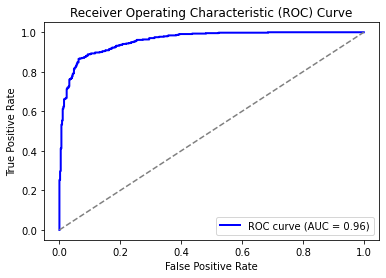

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 689ms/step - accuracy: 0.9223 - loss: 0.1737 - val_accuracy: 0.8619 - val_loss: 0.3676
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - accuracy: 0.9527 - loss: 0.1391 - val_accuracy: 0.8619 - val_loss: 0.3317
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.9605 - loss: 0.1076 - val_accuracy: 0.8476 - val_loss: 0.4000
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9478 - loss: 0.1281 - val_accuracy: 0.8905 - val_loss: 0.3860
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9637 - loss: 0.0809 - val_accuracy: 0.7810 - val_loss: 0.7415
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.9360 - loss: 0.1758 - val_accuracy: 0.8548 - val_loss: 0.4591
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9503 - loss: 0.1143 - val_accuracy: 0.8810 - val_loss: 0.3536
Training Time: 254.450523853302 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 531ms/step
Inference Time: 15.68796706199646 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step - accuracy: 0.8549 - loss: 0.3527
Validation Loss: 0.3316909372806549
Validation Accuracy: 0.8619047403335571
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 534ms/step - accuracy: 0.8719 - loss: 0.2714
Test Loss: 0.2934019863605499
Test Accuracy: 0.8788889050483704
ROC AUC Score: 0.9595511391992253
Confusion Matrix:
[[401  60]
 [ 49 390]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       461
           1       0.87      0.89      0.88       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



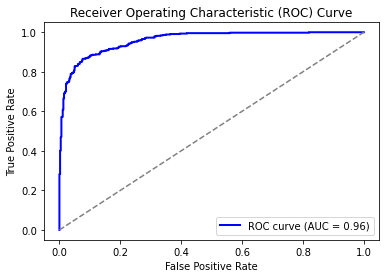

Metrics saved successfully


In [14]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [15]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - accuracy: 0.9390 - loss: 0.1316 - val_accuracy: 0.8214 - val_loss: 0.4881
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9514 - loss: 0.1203 - val_accuracy: 0.8738 - val_loss: 0.3385
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - accuracy: 0.9511 - loss: 0.1060 - val_accuracy: 0.8714 - val_loss: 0.3491
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9681 - loss: 0.0797 - val_accuracy: 0.8905 - val_loss: 0.3779
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9693 - loss: 0.0812 - val_accuracy: 0.8357 - val_loss: 0.4429
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.9404 - loss: 0.1201 - val_accuracy: 0.8595 - val_loss: 0.5247
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.9418 - loss: 0.1560 - val_accuracy: 0.8738 - val_loss: 0.3542
Training Time: 254.40693593025208 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step
Inference Time: 15.701304197311401 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 510ms/step - accuracy: 0.8617 - loss: 0.3455
Validation Loss: 0.3384608328342438
Validation Accuracy: 0.8738095164299011
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step - accuracy: 0.9034 - loss: 0.2529
Test Loss: 0.2916714549064636
Test Accuracy: 0.894444465637207
ROC AUC Score: 0.9635016478982503
Confusion Matrix:
[[417  44]
 [ 51 388]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       461
           1       0.90      0.88      0.89       439

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



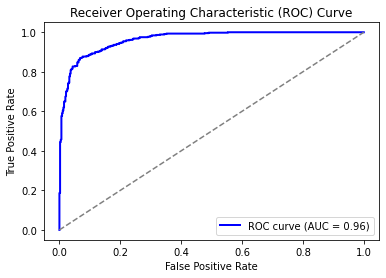

Metrics saved successfully


In [16]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [17]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - accuracy: 0.9524 - loss: 0.1075 - val_accuracy: 0.8762 - val_loss: 0.3061
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9370 - loss: 0.1422 - val_accuracy: 0.8881 - val_loss: 0.3378
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.9487 - loss: 0.1058 - val_accuracy: 0.8619 - val_loss: 0.4118
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - accuracy: 0.9757 - loss: 0.0605 - val_accuracy: 0.8857 - val_loss: 0.3758
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.9314 - loss: 0.1657 - val_accuracy: 0.8619 - val_loss: 0.3999
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - accuracy: 0.9668 - loss: 0.0853 - val_accuracy: 0.8357 - val_loss: 0.5244
Training Time: 217.97856521606445 seconds


29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 531ms/step
Inference Time: 15.694647789001465 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - accuracy: 0.8473 - loss: 0.3383
Validation Loss: 0.3060991168022156
Validation Accuracy: 0.8761904835700989
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step - accuracy: 0.8821 - loss: 0.2620
Test Loss: 0.2843337655067444
Test Accuracy: 0.8788889050483704
ROC AUC Score: 0.9628914067171002
Confusion Matrix:
[[382  79]
 [ 30 409]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       461
           1       0.84      0.93      0.88       439

    accuracy                           0.88       900
   macro avg       0.88      0.88      0.88       900
weighted avg       0.88      0.88      0.88       900



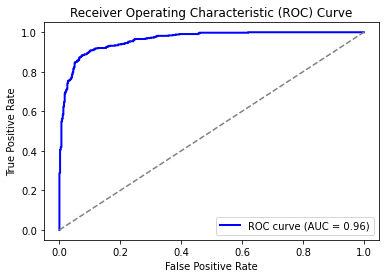

Metrics saved successfully


In [18]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_3000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_3000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")
 